In [3]:
import os
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

try:
    import sionna
except ImportError as e:
    import os
    os.system("pip install sionna==0.19")
    import sionna

import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
tf.get_logger().setLevel('ERROR')

sionna.config.seed = 42
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pickle

from tensorflow.keras import Model
from tensorflow.keras.layers import Layer, Conv2D, LayerNormalization
from tensorflow.nn import relu

from sionna.channel.tr38901 import Antenna, AntennaArray, CDL
from sionna.channel import OFDMChannel
from sionna.mimo import StreamManagement
from sionna.ofdm import ResourceGrid, ResourceGridMapper, LSChannelEstimator, LMMSEEqualizer, RemoveNulledSubcarriers, ResourceGridDemapper
from sionna.utils import BinarySource, ebnodb2no, insert_dims, flatten_last_dims, log10, expand_to_rank
from sionna.fec.ldpc.encoding import LDPC5GEncoder
from sionna.fec.ldpc.decoding import LDPC5GDecoder
from sionna.mapping import Mapper, Demapper
from sionna.utils.metrics import compute_ber
from sionna.utils import sim_ber

In [ ]:
carrier_frequency = 3.5e9
delay_spread = 100e-9
cdl_model = "C"
speed = 10.0
ebno_db_min = -5.0
ebno_db_max = 10.0

subcarrier_spacing = 30e3
fft_size = 128
num_ofdm_symbols = 14
dc_null = True
num_guard_carriers = [5, 6]
pilot_pattern = "kronecker"
pilot_ofdm_symbol_indices = [2, 11]
cyclic_prefix_length = 0

num_bits_per_symbol = 2
coderate = 0.5

num_conv_channels = 128

num_training_iterations = 3000
training_batch_size = 128
model_weights_path = "neural_receiver_weights"

results_filename = "neural_receiver_results"

stream_manager = StreamManagement(np.array([[1]]), 1)

resource_grid = ResourceGrid(num_ofdm_symbols = num_ofdm_symbols,
                             fft_size = fft_size,
                             subcarrier_spacing = subcarrier_spacing,
                             num_tx = 1,
                             num_streams_per_tx = 1,
                             cyclic_prefix_length = cyclic_prefix_length,
                             dc_null = dc_null,
                             pilot_pattern = pilot_pattern,
                             pilot_ofdm_symbol_indices = pilot_ofdm_symbol_indices,
                             num_guard_carriers = num_guard_carriers)

n = int(resource_grid.num_data_symbols * num_bits_per_symbol)
k = int(n * coderate)

ut_antenna = Antenna(polarization="single",
                     polarization_type="V",
                     antenna_pattern="38.901",
                     carrier_frequency=carrier_frequency)

bs_array = AntennaArray(num_rows=1,
                        num_cols=1,
                        polarization="dual",
                        polarization_type="VH",
                        antenna_pattern="38.901",
                        carrier_frequency=carrier_frequency)

In [5]:
## Transmitter
binary_source = BinarySource()
mapper = Mapper("qam", num_bits_per_symbol)
rg_mapper = ResourceGridMapper(resource_grid)

## Channel
cdl = CDL(cdl_model, delay_spread, carrier_frequency,
          ut_antenna, bs_array, "uplink", min_speed=speed)
channel = OFDMChannel(cdl, resource_grid, normalize_channel=True, return_channel=True)

## Receiver
neural_receiver = NeuralReceiver()
rg_demapper = ResourceGridDemapper(resource_grid, stream_manager) # Used to extract data-carrying resource elements

In [6]:
batch_size = 64
ebno_db = tf.fill([batch_size], 5.0)
no = ebnodb2no(ebno_db, num_bits_per_symbol, coderate)


## Transmitter
# Generate codewords
c = binary_source([batch_size, 1, 1, n])
print("c shape: ", c.shape)
# Map bits to QAM symbols
x = mapper(c)
print("x shape: ", x.shape)
# Map the QAM symbols to a resource grid
x_rg = rg_mapper(x)
print("x_rg shape: ", x_rg.shape)

######################################
## Channel
# A batch of new channel realizations is sampled and applied at every inference
no_ = expand_to_rank(no, tf.rank(x_rg))
y,_ = channel([x_rg, no_])
print("y shape: ", y.shape)

######################################
## Receiver
# The neural receiver computes LLRs from the frequency domain received symbols and N0
y = tf.squeeze(y, axis=1)
llr = neural_receiver([y, no])
print("llr shape: ", llr.shape)
# Reshape the input to fit what the resource grid demapper is expected
llr = insert_dims(llr, 2, 1)
# Extract data-carrying resource elements. The other LLRs are discarded
llr = rg_demapper(llr)
llr = tf.reshape(llr, [batch_size, 1, 1, n])
print("Post RG-demapper LLRs: ", llr.shape)

c shape:  (64, 1, 1, 2784)
x shape:  (64, 1, 1, 1392)
x_rg shape:  (64, 1, 1, 14, 128)
y shape:  (64, 1, 2, 14, 128)
llr shape:  (64, 14, 128, 2)
Post RG-demapper LLRs:  (64, 1, 1, 2784)


In [7]:
import os
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

try:
    import sionna
except ImportError as e:
    import os
    os.system("pip install sionna==0.19")
    import sionna

import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
tf.get_logger().setLevel('ERROR')

sionna.config.seed = 42
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pickle

from tensorflow.keras import Model
from tensorflow.keras.layers import Layer, Dense
from tensorflow.nn import relu, tanh  # Added tanh for ESN activation

from sionna.channel.tr38901 import Antenna, AntennaArray, CDL
from sionna.channel import OFDMChannel
from sionna.mimo import StreamManagement
from sionna.ofdm import ResourceGrid, ResourceGridMapper, LSChannelEstimator, LMMSEEqualizer, RemoveNulledSubcarriers, ResourceGridDemapper
from sionna.utils import BinarySource, ebnodb2no, insert_dims, flatten_last_dims, log10, expand_to_rank
from sionna.fec.ldpc.encoding import LDPC5GEncoder
from sionna.fec.ldpc.decoding import LDPC5GDecoder
from sionna.mapping import Mapper, Demapper
from sionna.utils.metrics import compute_ber
from sionna.utils import sim_ber

carrier_frequency = 3.5e9
delay_spread = 100e-9
cdl_model = "C"
speed = 10.0
ebno_db_min = -5.0
ebno_db_max = 10.0

subcarrier_spacing = 30e3
fft_size = 128
num_ofdm_symbols = 14
dc_null = True
num_guard_carriers = [5, 6]
pilot_pattern = "kronecker"
pilot_ofdm_symbol_indices = [2, 11]
cyclic_prefix_length = 0

num_bits_per_symbol = 2
coderate = 0.5

# ESN hyperparameters (tune these; inspired by papers: units ~ subcarriers, leak=0.1-0.5)
esn_units = 256  # Reservoir size
leak_rate = 0.1  # Leaky integrator rate
spectral_radius = 0.99  # For echo state property

num_training_iterations = 30000
training_batch_size = 128
model_weights_path = "esn_receiver_weights"

results_filename = "esn_receiver_results"

stream_manager = StreamManagement(np.array([[1]]), 1)

resource_grid = ResourceGrid(num_ofdm_symbols = num_ofdm_symbols,
                             fft_size = fft_size,
                             subcarrier_spacing = subcarrier_spacing,
                             num_tx = 1,
                             num_streams_per_tx = 1,
                             cyclic_prefix_length = cyclic_prefix_length,
                             dc_null = dc_null,
                             pilot_pattern = pilot_pattern,
                             pilot_ofdm_symbol_indices = pilot_ofdm_symbol_indices,
                             num_guard_carriers = num_guard_carriers)

n = int(resource_grid.num_data_symbols * num_bits_per_symbol)
k = int(n * coderate)

ut_antenna = Antenna(polarization="single",
                     polarization_type="V",
                     antenna_pattern="38.901",
                     carrier_frequency=carrier_frequency)

bs_array = AntennaArray(num_rows=1,
                        num_cols=1,
                        polarization="dual",
                        polarization_type="VH",
                        antenna_pattern="38.901",
                        carrier_frequency=carrier_frequency)

# New: Define ESNCell as a custom RNN cell (fixed reservoir, trainable readout later)
class ESNCell(tf.keras.layers.AbstractRNNCell):
    def __init__(self, units, leak_rate, spectral_radius, **kwargs):
        super(ESNCell, self).__init__(**kwargs)
        self.units = units
        self.leak_rate = leak_rate
        self.spectral_radius = spectral_radius

    @property
    def state_size(self):
        return self.units

    def build(self, input_shape):
        input_dim = input_shape[-1]
        # Random input weights (fixed)
        self.W_in = self.add_weight(shape=(input_dim, self.units),
                                    initializer='random_normal',
                                    trainable=False,  # Fixed in ESN
                                    name='W_in')
        # Random reservoir weights (fixed, scaled for spectral radius)
        W_res = tf.random.normal([self.units, self.units])
        eigvals = tf.linalg.eigvals(W_res)
        rho = tf.reduce_max(tf.abs(eigvals))
        W_res = W_res * (self.spectral_radius / (rho + 1e-8))  # Avoid div by zero
        self.W_res = self.add_weight(shape=(self.units, self.units),
                                     initializer=tf.constant_initializer(W_res.numpy()),
                                     trainable=False,  # Fixed
                                     name='W_res')
        # Bias (optional, fixed)
        self.bias = self.add_weight(shape=(self.units,),
                                    initializer='zeros',
                                    trainable=False,
                                    name='bias')

    def call(self, inputs, states):
        state = states[0]
        # ESN update: leaky + tanh (from papers)
        pre_activation = tf.matmul(inputs, self.W_in) + tf.matmul(state, self.W_res) + self.bias
        new_state = (1 - self.leak_rate) * state + self.leak_rate * tf.tanh(pre_activation)
        return new_state, [new_state]

# Modified NeuralReceiver using ESN
class NeuralReceiver(Layer):
    def build(self, input_shape):
        # ESN cell
        self.esn_cell = ESNCell(units=esn_units, leak_rate=leak_rate, spectral_radius=spectral_radius)
        # Trainable readout: Dense to output LLRs (only this is trained)
        self.readout = Dense(num_bits_per_symbol, activation=None)  # Linear for logits/LLRs

    def call(self, inputs):
        y, no = inputs
        no = log10(no)
        # Transpose to [batch, symbols, subcarriers, rx_ant]
        y = tf.transpose(y, [0, 2, 3, 1])
        no = insert_dims(no, 3, 1)
        no = tf.tile(no, [1, y.shape[1], y.shape[2], 1])
        # Concat real/imag/no: [batch, symbols, subcarriers, features=2*rx +1]
        z = tf.concat([tf.math.real(y), tf.math.imag(y), no], axis=-1)
        # Reshape for RNN: treat symbols as time steps, flatten subcarriers*features as input dim
        batch_size, num_symbols, num_subc, features = tf.shape(z)
        input_seq = tf.reshape(z, [batch_size, num_symbols, num_subc * features])
        # Run ESN RNN over symbols (time)
        outputs, _ = tf.keras.layers.RNN(self.esn_cell, return_sequences=True)(input_seq)
        # Reshape back: [batch, symbols, subcarriers, esn_units] (approx, may need adjust if not divisible)
        outputs = tf.reshape(outputs, [batch_size, num_symbols, num_subc, esn_units])
        # Readout to LLRs: [batch, symbols, subcarriers, num_bits_per_symbol]
        llr = self.readout(outputs)
        return llr

# The rest of the code remains the same (E2ESystem, training, evaluation, plotting)
# Replace 'neural-receiver' with 'esn-receiver' in model instantiations if desired
# Example: model = E2ESystem('neural-receiver', training=True) -> use ESN version above

class E2ESystem(Model):
    def __init__(self, system, training=False):
        super().__init__()
        self._system = system
        self._training = training
        self._binary_source = BinarySource()
        if not training:
            self._encoder = LDPC5GEncoder(k, n)
        self._mapper = Mapper("qam", num_bits_per_symbol)
        self._rg_mapper = ResourceGridMapper(resource_grid)
        cdl = CDL(cdl_model, delay_spread, carrier_frequency,
                  ut_antenna, bs_array, "uplink", min_speed=speed)
        self._channel = OFDMChannel(cdl, resource_grid, normalize_channel=True, return_channel=True)
        if "baseline" in system:
            if system == 'baseline-perfect-csi':
                self._removed_null_subc = RemoveNulledSubcarriers(resource_grid)
            elif system == 'baseline-ls-estimation':
                self._ls_est = LSChannelEstimator(resource_grid, interpolation_type="nn")
            self._lmmse_equ = LMMSEEqualizer(resource_grid, stream_manager)
            self._demapper = Demapper("app", "qam", num_bits_per_symbol)
        elif system == "neural-receiver":  # Now ESN-based
            self._neural_receiver = NeuralReceiver()
            self._rg_demapper = ResourceGridDemapper(resource_grid, stream_manager)
        if not training:
            self._decoder = LDPC5GDecoder(self._encoder, hard_out=True)

    @tf.function
    def call(self, batch_size, ebno_db):
        if len(ebno_db.shape) == 0:
            ebno_db = tf.fill([batch_size], ebno_db)
        no = ebnodb2no(ebno_db, num_bits_per_symbol, coderate)
        if self._training:
            c = self._binary_source([batch_size, 1, 1, n])
        else:
            b = self._binary_source([batch_size, 1, 1, k])
            c = self._encoder(b)
        x = self._mapper(c)
        x_rg = self._rg_mapper(x)
        no_ = expand_to_rank(no, tf.rank(x_rg))
        y, h = self._channel([x_rg, no_])
        if "baseline" in self._system:
            if self._system == 'baseline-perfect-csi':
                h_hat = self._removed_null_subc(h)
                err_var = 0.0
            elif self._system == 'baseline-ls-estimation':
                h_hat, err_var = self._ls_est([y, no])
            x_hat, no_eff = self._lmmse_equ([y, h_hat, err_var, no])
            no_eff_ = expand_to_rank(no_eff, tf.rank(x_hat))
            llr = self._demapper([x_hat, no_eff_])
        elif self._system == "neural-receiver":
            y = tf.squeeze(y, axis=1)
            llr = self._neural_receiver([y, no])
            llr = insert_dims(llr, 2, 1)
            llr = self._rg_demapper(llr)
            llr = tf.reshape(llr, [batch_size, 1, 1, n])
        if self._training:
            bce = tf.nn.sigmoid_cross_entropy_with_logits(c, llr)
            bce = tf.reduce_mean(bce)
            rate = tf.constant(1.0, tf.float32) - bce / tf.math.log(2.)
            return rate
        else:
            b_hat = self._decoder(llr)
            return b, b_hat

ebno_dbs = np.arange(ebno_db_min, ebno_db_max + 0.5, 0.5)

BLER = {}

model = E2ESystem('baseline-perfect-csi')
_, bler = sim_ber(model, ebno_dbs, batch_size=128, num_target_block_errors=100, max_mc_iter=100)
BLER['baseline-perfect-csi'] = bler.numpy()

model = E2ESystem('baseline-ls-estimation')
_, bler = sim_ber(model, ebno_dbs, batch_size=128, num_target_block_errors=100, max_mc_iter=100)
BLER['baseline-ls-estimation'] = bler.numpy()

model = E2ESystem('neural-receiver', training=True)  # Now ESN
optimizer = tf.keras.optimizers.Adam()
for i in range(num_training_iterations):
    ebno_db = tf.random.uniform(shape=[], minval=ebno_db_min, maxval=ebno_db_max)
    with tf.GradientTape() as tape:
        rate = model(training_batch_size, ebno_db)
        loss = -rate
    weights = model.trainable_weights  # Only readout weights are trainable
    grads = tape.gradient(loss, weights)
    optimizer.apply_gradients(zip(grads, weights))
    if i % 100 == 0:
        print('Iteration {}/{}  Rate: {:.4f} bit'.format(i, num_training_iterations, rate.numpy()), end='\r')

weights = model.get_weights()
with open(model_weights_path, 'wb') as f:
    pickle.dump(weights, f)

model = E2ESystem('neural-receiver')
model(1, tf.constant(10.0, tf.float32))
with open(model_weights_path, 'rb') as f:
    weights = pickle.load(f)
model.set_weights(weights)

_, bler = sim_ber(model, ebno_dbs, batch_size=128, num_target_block_errors=100, max_mc_iter=100)
BLER['neural-receiver'] = bler.numpy()  # Now ESN results

plt.figure(figsize=(10,6))
plt.semilogy(ebno_dbs, BLER['baseline-perfect-csi'], 'o-', c='C0', label='Baseline - Perfect CSI')
plt.semilogy(ebno_dbs, BLER['baseline-ls-estimation'], 'x--', c='C1', label='Baseline - LS Estimation')
plt.semilogy(ebno_dbs, BLER['neural-receiver'], 's-.', c='C2', label='ESN receiver')
plt.xlabel(r"$E_b/N_0$ (dB)")
plt.ylabel("BLER")
plt.grid(which="both")
plt.ylim((1e-4, 1.0))
plt.legend()
plt.tight_layout()
plt.show()

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 2.5164e-01 | 1.0000e+00 |       44836 |      178176 |          128 |         128 |         3.5 |reached target block errors
     -4.5 | 2.3636e-01 | 1.0000e+00 |       42113 |      178176 |          128 |         128 |         0.7 |reached target block errors
     -4.0 | 2.1841e-01 | 1.0000e+00 |       38916 |      178176 |          128 |         128 |         0.6 |reached target block errors
     -3.5 | 1.9390e-01 | 1.0000e+00 |       34549 |      178176 |          128 |         128 |         0.6 |reached target block errors
     -3.0 | 1.6739e-01 | 1.0000e+00 |       29825 |      178176 |          128 |         128 |         0.6 |reached target block errors
     -2.5 | 1.0718e-01 | 1.0000e+00 |       19097 |      178176 |

OperatorNotAllowedInGraphError: Exception encountered when calling layer 'e2e_system_3' (type E2ESystem).

in user code:

    File "/tmp/ipykernel_76648/2518273832.py", line 226, in call  *
        llr = self._neural_receiver([y, no])
    File "/home/aoschu/anaconda3/envs/OpenNTN/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler  **
        raise e.with_traceback(filtered_tb) from None

    OperatorNotAllowedInGraphError: Exception encountered when calling layer 'neural_receiver_1' (type NeuralReceiver).
    
    in user code:
    
        File "/tmp/ipykernel_76648/2518273832.py", line 161, in call  *
            batch_size, num_symbols, num_subc, features = tf.shape(z)
    
        OperatorNotAllowedInGraphError: Iterating over a symbolic `tf.Tensor` is not allowed. You can attempt the following resolutions to the problem: If you are running in Graph mode, use Eager execution mode or decorate this function with @tf.function. If you are using AutoGraph, you can try decorating this function with @tf.function. If that does not work, then you may be using an unsupported feature or your source code may not be visible to AutoGraph. See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/g3doc/reference/limitations.md#access-to-source-code for more information.
    
    
    Call arguments received by layer 'neural_receiver_1' (type NeuralReceiver):
      • inputs=['tf.Tensor(shape=(None, 2, 14, 128), dtype=complex64)', 'tf.Tensor(shape=(None,), dtype=float32)']


Call arguments received by layer 'e2e_system_3' (type E2ESystem):
  • batch_size=tf.Tensor(shape=(), dtype=int32)
  • ebno_db=tf.Tensor(shape=(), dtype=float32)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      1.0 | 5.0017e-01 | 1.0000e+00 |       89118 |      178176 |          128 |         128 |         0.6 |reached target block errors
      2.0 | 4.9784e-01 | 1.0000e+00 |       88703 |      178176 |          128 |         128 |         0.6 |reached target block errors
      3.0 | 4.9969e-01 | 1.0000e+00 |       89033 |      178176 |          128 |         128 |         0.6 |reached target block errors
      4.0 | 5.0180e-01 | 1.0000e+00 |       89409 |      178176 |          128 |         128 |         0.5 |reached target block errors
      5.0 | 5.0028e-01 | 1.0000e+00 |       89137 |      178176 |          128 |         128 |         0.5 |reached target block errors


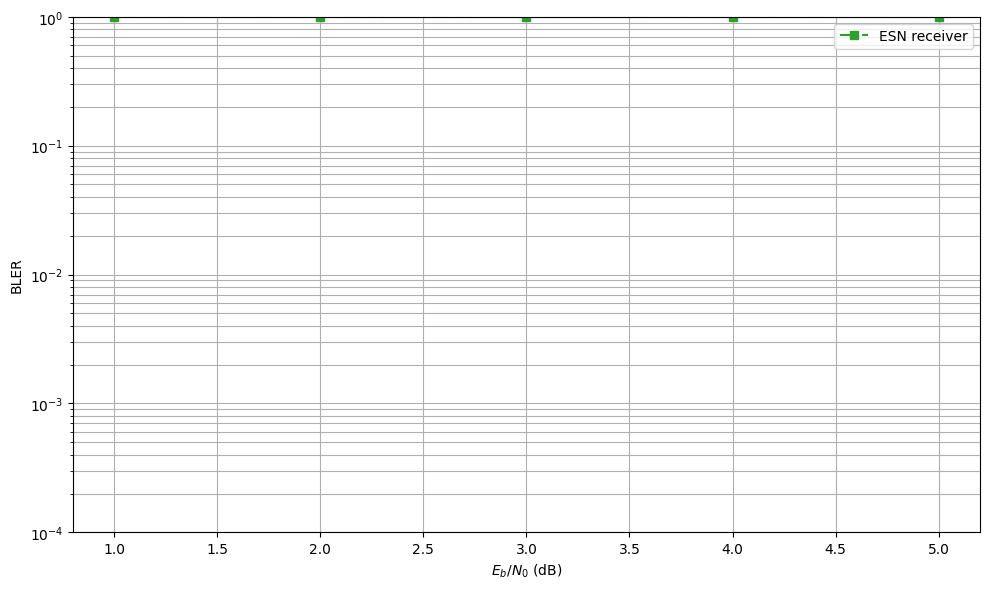

In [16]:
import os
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

try:
    import sionna
except ImportError as e:
    import os
    os.system("pip install sionna==0.19")
    import sionna

import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
tf.get_logger().setLevel('ERROR')

sionna.config.seed = 42
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pickle

from tensorflow.keras import Model
from tensorflow.keras.layers import Layer, Dense
from tensorflow.nn import relu, tanh

from sionna.channel.tr38901 import Antenna, AntennaArray, CDL
from sionna.channel import OFDMChannel
from sionna.mimo import StreamManagement
from sionna.ofdm import ResourceGrid, ResourceGridMapper, LSChannelEstimator, LMMSEEqualizer, RemoveNulledSubcarriers, ResourceGridDemapper
from sionna.utils import BinarySource, ebnodb2no, insert_dims, flatten_last_dims, log10, expand_to_rank
from sionna.fec.ldpc.encoding import LDPC5GEncoder
from sionna.fec.ldpc.decoding import LDPC5GDecoder
from sionna.mapping import Mapper, Demapper
from sionna.utils.metrics import compute_ber
from sionna.utils import sim_ber

carrier_frequency = 3.5e9
delay_spread = 100e-9
cdl_model = "C"
speed = 10.0
ebno_db_min = -5.0
ebno_db_max = 10.0

subcarrier_spacing = 30e3
fft_size = 128
num_ofdm_symbols = 14
dc_null = True
num_guard_carriers = [5, 6]
pilot_pattern = "kronecker"
pilot_ofdm_symbol_indices = [2, 11]
cyclic_prefix_length = 0

num_bits_per_symbol = 2
coderate = 0.5

esn_units = 256
leak_rate = 0.1
spectral_radius = 0.99

num_training_iterations = 3000
training_batch_size = 128
model_weights_path = "esn_receiver_weights"

results_filename = "esn_receiver_results"

stream_manager = StreamManagement(np.array([[1]]), 1)

resource_grid = ResourceGrid(num_ofdm_symbols = num_ofdm_symbols,
                             fft_size = fft_size,
                             subcarrier_spacing = subcarrier_spacing,
                             num_tx = 1,
                             num_streams_per_tx = 1,
                             cyclic_prefix_length = cyclic_prefix_length,
                             dc_null = dc_null,
                             pilot_pattern = pilot_pattern,
                             pilot_ofdm_symbol_indices = pilot_ofdm_symbol_indices,
                             num_guard_carriers = num_guard_carriers)

n = int(resource_grid.num_data_symbols * num_bits_per_symbol)
k = int(n * coderate)

ut_antenna = Antenna(polarization="single",
                     polarization_type="V",
                     antenna_pattern="38.901",
                     carrier_frequency=carrier_frequency)

bs_array = AntennaArray(num_rows=1,
                        num_cols=1,
                        polarization="dual",
                        polarization_type="VH",
                        antenna_pattern="38.901",
                        carrier_frequency=carrier_frequency)

class NeuralReceiver(Layer):
    def __init__(self):
        super().__init__()
        self.readout = Dense(num_bits_per_symbol, activation=None)
        # Precompute fixed weights
        self.sw = tf.Variable(1.0, trainable=True)  # Scalable if needed
        self.rho = tf.Variable(1.0, trainable=True)
        self.decay_var = tf.Variable(leak_rate, trainable=True)
        self.alpha_var = tf.Variable(0.5, trainable=True)
        rng = np.random.RandomState(42)
        self.w_in = tf.constant(rng.normal(size=(fft_size * 5, esn_units)), dtype=tf.float32)  # Input dim = 128*5 = 640
        w_res_np = rng.normal(size=(esn_units, esn_units))
        eigvals_np = np.linalg.eigvals(w_res_np)
        rho_np = np.max(np.abs(eigvals_np))
        w_res_scaled = w_res_np * (spectral_radius / (rho_np + 1e-8))
        self.w_res = tf.constant(w_res_scaled, dtype=tf.float32)
        self.bias = tf.zeros((esn_units,))

    def call(self, inputs):
        y, no = inputs
        no = log10(no)
        y = tf.transpose(y, [0, 2, 3, 1])  # [batch, symbols=14, subcarriers=128, rx=2]
        no = insert_dims(no, 3, 1)
        no = tf.tile(no, [1, num_ofdm_symbols, fft_size, 1])
        z = tf.concat([tf.math.real(y), tf.math.imag(y), no], axis=-1)  # [batch, 14, 128, 5]
        batch_size = tf.shape(z)[0]
        z = tf.reshape(z, [batch_size, num_ofdm_symbols, fft_size * 5])  # [batch, 14, 640]

        # Initialize state
        state = tf.zeros([batch_size, esn_units])
        outputs = []
        for t in range(num_ofdm_symbols):
            inputs_t = z[:, t, :] * self.sw
            pre_activation = tf.matmul(inputs_t, self.w_in) + tf.matmul(state, self.w_res) + self.bias
            new_state = (1 - self.decay_var) * state + self.decay_var * tanh(self.alpha_var * pre_activation)
            outputs.append(new_state)
            state = new_state
        outputs = tf.stack(outputs, axis=1)  # [batch, 14, esn_units]
        outputs = tf.reshape(outputs, [batch_size, num_ofdm_symbols, fft_size, esn_units // fft_size]) if esn_units % fft_size == 0 else outputs[:, :, None, :]  # Adjust if needed, but for 256/128=2, reshape to [batch, 14, 128, 2]
        # If esn_units not divisible, keep as is and adjust readout
        llr = self.readout(outputs)  # Apply readout to [batch, 14, 128, esn_units] -> [batch, 14, 128, 2]
        return llr

class E2ESystem(Model):
    def __init__(self, system, training=False):
        super().__init__()
        self._system = system
        self._training = training
        self._binary_source = BinarySource()
        if not training:
            self._encoder = LDPC5GEncoder(k, n)
        self._mapper = Mapper("qam", num_bits_per_symbol)
        self._rg_mapper = ResourceGridMapper(resource_grid)
        cdl = CDL(cdl_model, delay_spread, carrier_frequency,
                  ut_antenna, bs_array, "uplink", min_speed=speed)
        self._channel = OFDMChannel(cdl, resource_grid, normalize_channel=True, return_channel=True)
        if "baseline" in system:
            if system == 'baseline-perfect-csi':
                self._removed_null_subc = RemoveNulledSubcarriers(resource_grid)
            elif system == 'baseline-ls-estimation':
                self._ls_est = LSChannelEstimator(resource_grid, interpolation_type="nn")
            self._lmmse_equ = LMMSEEqualizer(resource_grid, stream_manager)
            self._demapper = Demapper("app", "qam", num_bits_per_symbol)
        elif system == "neural-receiver":
            self._neural_receiver = NeuralReceiver()
            self._rg_demapper = ResourceGridDemapper(resource_grid, stream_manager)
        if not training:
            self._decoder = LDPC5GDecoder(self._encoder, hard_out=True)

    @tf.function(jit_compile=False)
    def call(self, batch_size, ebno_db):
        if len(ebno_db.shape) == 0:
            ebno_db = tf.fill([batch_size], ebno_db)
        no = ebnodb2no(ebno_db, num_bits_per_symbol, coderate)
        if self._training:
            c = self._binary_source([batch_size, 1, 1, n])
        else:
            b = self._binary_source([batch_size, 1, 1, k])
            c = self._encoder(b)
        x = self._mapper(c)
        x_rg = self._rg_mapper(x)
        no_ = expand_to_rank(no, tf.rank(x_rg))
        y, h = self._channel([x_rg, no_])
        if "baseline" in self._system:
            if self._system == 'baseline-perfect-csi':
                h_hat = self._removed_null_subc(h)
                err_var = 0.0
            elif self._system == 'baseline-ls-estimation':
                h_hat, err_var = self._ls_est([y, no])
            x_hat, no_eff = self._lmmse_equ([y, h_hat, err_var, no])
            no_eff_ = expand_to_rank(no_eff, tf.rank(x_hat))
            llr = self._demapper([x_hat, no_eff_])
        elif self._system == "neural-receiver":
            y = tf.squeeze(y, axis=1)
            llr = self._neural_receiver([y, no])
            llr = insert_dims(llr, 2, 1)
            llr = self._rg_demapper(llr)
            llr = tf.reshape(llr, [batch_size, 1, 1, n])
        if self._training:
            bce = tf.nn.sigmoid_cross_entropy_with_logits(c, llr)
            bce = tf.reduce_mean(bce)
            rate = tf.constant(1.0, tf.float32) - bce / tf.math.log(2.)
            return rate
        else:
            b_hat = self._decoder(llr)
            return b, b_hat

ebno_dbs = np.arange(1, 5 + 0.5, 1)

BLER = {}
"""
model = E2ESystem('baseline-perfect-csi')
_, bler = sim_ber(model, ebno_dbs, batch_size=128, num_target_block_errors=100, max_mc_iter=100)
BLER['baseline-perfect-csi'] = bler.numpy()

model = E2ESystem('baseline-ls-estimation')
_, bler = sim_ber(model, ebno_dbs, batch_size=128, num_target_block_errors=100, max_mc_iter=100)
BLER['baseline-ls-estimation'] = bler.numpy()
"""
model = E2ESystem('neural-receiver', training=True)
optimizer = tf.keras.optimizers.Adam()
for i in range(num_training_iterations):
    ebno_db = tf.random.uniform(shape=[], minval=ebno_db_min, maxval=ebno_db_max)
    with tf.GradientTape() as tape:
        rate = model(training_batch_size, ebno_db)
        loss = -rate
    weights = model.trainable_weights
    grads = tape.gradient(loss, weights)
    optimizer.apply_gradients(zip(grads, weights))
    if i % 100 == 0:
        print('Iteration {}/{}  Rate: {:.4f} bit'.format(i, num_training_iterations, rate.numpy()), end='\r')

weights = model.get_weights()
with open(model_weights_path, 'wb') as f:
    pickle.dump(weights, f)

model = E2ESystem('neural-receiver')
model(1, tf.constant(10.0, tf.float32))
with open(model_weights_path, 'rb') as f:
    weights = pickle.load(f)
model.set_weights(weights)

_, bler = sim_ber(model, ebno_dbs, batch_size=128, num_target_block_errors=100, max_mc_iter=100)
BLER['neural-receiver'] = bler.numpy()

plt.figure(figsize=(10,6))
#plt.semilogy(ebno_dbs, BLER['baseline-perfect-csi'], 'o-', c='C0', label='Baseline - Perfect CSI')
#plt.semilogy(ebno_dbs, BLER['baseline-ls-estimation'], 'x--', c='C1', label='Baseline - LS Estimation')
plt.semilogy(ebno_dbs, BLER['neural-receiver'], 's-.', c='C2', label='ESN receiver')
plt.xlabel(r"$E_b/N_0$ (dB)")
plt.ylabel("BLER")
plt.grid(which="both")
plt.ylim((1e-4, 1.0))
plt.legend()
plt.tight_layout()
plt.show()

In [3]:
import os
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

try:
    import sionna
except ImportError as e:
    import os
    os.system("pip install sionna==0.19.2")
    import sionna

import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
tf.get_logger().setLevel('ERROR')

sionna.config.seed = 42
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pickle

from tensorflow.keras import Model
from tensorflow.keras.layers import Layer, Dense
from tensorflow.nn import tanh

from sionna.mimo import StreamManagement
from sionna.utils import BinarySource, sim_ber, ebnodb2no
from sionna.mapping import Mapper
from sionna.ofdm import ResourceGrid, ResourceGridMapper, ResourceGridDemapper
from sionna.channel import OFDMChannel
from sionna.channel.tr38901 import CDL, Antenna
from sionna.fec.ldpc import LDPC5GEncoder, LDPC5GDecoder

# Simulation parameters
NUM_OFDM_SYMBOLS = 14
FFT_SIZE = 128
SUBCARRIER_SPACING = 30e3  # Hz
CARRIER_FREQUENCY = 3.5e9  # Hz
SPEED = 10.0  # m/s
DELAY_SPREAD = 100e-9
CDL_MODEL = "C"

NUM_TX = 1
NUM_RX_ANT = 1  # SISO configuration
NUM_BITS_PER_SYMBOL = 2  # QPSK
CODERATE = 0.5

esn_units = 256
leak_rate = 0.1
spectral_radius = 0.99
num_training_iterations = 3000
training_batch_size = 128
model_weights_path = "esn_siso_cdl_weights"
ebno_db_min = -5.0
ebno_db_max = 10.0
EBN0_DBs = np.linspace(1.0, 5.0, 5)

# Antenna configuration
UT_ANTENNA = Antenna(polarization="single",
                     polarization_type="V",
                     antenna_pattern="38.901",
                     carrier_frequency=CARRIER_FREQUENCY)

BS_ANTENNA = Antenna(polarization="single",
                     polarization_type="V",
                     antenna_pattern="38.901",
                     carrier_frequency=CARRIER_FREQUENCY)

# CDL channel model
CHANNEL_MODEL = CDL(model=CDL_MODEL,
                    delay_spread=DELAY_SPREAD,
                    carrier_frequency=CARRIER_FREQUENCY,
                    ut_array=UT_ANTENNA,
                    bs_array=BS_ANTENNA,
                    direction="uplink",
                    min_speed=SPEED)

# Resource grid
rg = ResourceGrid(num_ofdm_symbols=NUM_OFDM_SYMBOLS,
                  fft_size=FFT_SIZE,
                  subcarrier_spacing=SUBCARRIER_SPACING,
                  num_tx=NUM_TX,
                  num_streams_per_tx=1,
                  cyclic_prefix_length=0,
                  dc_null=True,
                  pilot_pattern="kronecker",
                  pilot_ofdm_symbol_indices=[2,11],
                  num_guard_carriers=[5,6])

# Stream management
sm = StreamManagement(np.array([[1]]), 1)

# Codeword length and number of information bits
n = int(rg.num_data_symbols * NUM_BITS_PER_SYMBOL)
k = int(n * CODERATE)

class NeuralReceiver(Layer):
    def __init__(self):
        super().__init__()
        self.readout = Dense(NUM_BITS_PER_SYMBOL, activation=None)
        self.sw = tf.Variable(1.0, trainable=True)
        self.decay_var = tf.Variable(leak_rate, trainable=True)
        self.alpha_var = tf.Variable(0.5, trainable=True)
        rng = np.random.RandomState(42)
        input_dim = FFT_SIZE * (2 * NUM_RX_ANT + 1)  # Real, Imag, Noise = 128 * 3 = 384
        self.w_in = tf.constant(rng.normal(size=(input_dim, esn_units)), dtype=tf.float32)
        w_res_np = rng.normal(size=(esn_units, esn_units))
        eigvals_np = np.linalg.eigvals(w_res_np)
        rho_np = np.max(np.abs(eigvals_np))
        w_res_scaled = w_res_np * (spectral_radius / (rho_np + 1e-8))
        self.w_res = tf.constant(w_res_scaled, dtype=tf.float32)
        self.bias = tf.zeros((esn_units,))

    def call(self, inputs):
        y, no = inputs
        tf.print("y shape:", tf.shape(y))  # Debug: Should be [batch, 14, 128, 1]
        tf.print("no shape:", tf.shape(no))  # Debug: Should be [batch]
        no = tf.math.log(no) / tf.math.log(10.0)  # Workaround for log10
        y = tf.transpose(y, [0, 1, 2, 3])  # [batch, ofdm, fft, rx_ant]
        y_real = tf.math.real(y)
        y_imag = tf.math.imag(y)
        y_ri = tf.concat([y_real, y_imag], axis=-1)  # [batch, ofdm, fft, 2*rx_ant]
        no = tf.expand_dims(no, axis=1)
        no = tf.expand_dims(no, axis=1)
        no = tf.expand_dims(no, axis=1)
        no = tf.tile(no, [1, NUM_OFDM_SYMBOLS, FFT_SIZE, 1])  # [batch, ofdm, fft, 1]
        z = tf.concat([y_ri, no], axis=-1)  # [batch, ofdm, fft, 2*rx_ant + 1]
        batch_size = tf.shape(z)[0]
        z = tf.reshape(z, [batch_size, NUM_OFDM_SYMBOLS, FFT_SIZE * (2 * NUM_RX_ANT + 1)])  # [batch, ofdm, 384]
        state = tf.zeros([batch_size, esn_units])
        outputs = []
        for t in range(NUM_OFDM_SYMBOLS):
            inputs_t = z[:, t, :] * self.sw
            pre_activation = tf.matmul(inputs_t, self.w_in) + tf.matmul(state, self.w_res) + self.bias
            new_state = (1 - self.decay_var) * state + self.decay_var * tanh(self.alpha_var * pre_activation)
            outputs.append(new_state)
            state = new_state
        outputs = tf.stack(outputs, axis=1)  # [batch, ofdm, esn_units]
        outputs = tf.reshape(outputs, [batch_size, NUM_OFDM_SYMBOLS, FFT_SIZE, esn_units // FFT_SIZE])  # [batch, ofdm, fft, 2]
        llr = self.readout(outputs)  # [batch, ofdm, fft, num_bits_per_symbol]
        tf.print("llr shape:", tf.shape(llr))  # Debug: Should be [batch, 14, 128, 2]
        return llr

class E2ESystem(Model):
    def __init__(self, training=False):
        super().__init__()
        self._training = training
        self._binary_source = BinarySource()
        if not training:
            self._encoder = LDPC5GEncoder(k, n, num_bits_per_symbol=NUM_BITS_PER_SYMBOL)
        self._mapper = Mapper(constellation_type="qam", num_bits_per_symbol=NUM_BITS_PER_SYMBOL)
        self._rg_mapper = ResourceGridMapper(rg)
        self._channel = OFDMChannel(CHANNEL_MODEL, rg, normalize_channel=True, return_channel=True)
        self._neural_receiver = NeuralReceiver()
        self._rg_demapper = ResourceGridDemapper(rg, sm)
        if not training:
            self._decoder = LDPC5GDecoder(self._encoder, hard_out=True)

    def call(self, batch_size, ebno_db):
        if tf.rank(ebno_db) == 0:
            ebno_db = tf.fill([batch_size], ebno_db)
        no = ebnodb2no(ebno_db, NUM_BITS_PER_SYMBOL, CODERATE, resource_grid=rg)
        if self._training:
            c = self._binary_source([batch_size, NUM_TX, 1, n])
        else:
            b = self._binary_source([batch_size, NUM_TX, 1, k])
            c = self._encoder(b)
        x = self._mapper(c)
        x_rg = self._rg_mapper(x)
        no_ = tf.cast(tf.expand_dims(no, axis=-1), tf.float32)
        y, h = self._channel([x_rg, no_])
        tf.print("y shape before squeeze:", tf.shape(y))  # Debug: Should be [batch, 1, 1, 14, 128]
        y = tf.squeeze(y, axis=2)  # Remove num_streams_per_tx dimension
        tf.print("y shape before neural receiver:", tf.shape(y))  # Debug: Should be [batch, 1, 14, 128]
        llr = self._neural_receiver([y, no])
        llr = tf.expand_dims(llr, axis=3)
        llr = tf.transpose(llr, [0, 3, 1, 2, 4])
        tf.print("llr shape before demapper:", tf.shape(llr))  # Debug: Should be [batch, 1, 14, 128, 2]
        llr = self._rg_demapper(llr)
        llr = tf.reshape(llr, [batch_size, NUM_TX, 1, n])
        tf.print("llr shape after demapper:", tf.shape(llr))  # Debug: Should be [batch, 1, 1, n]
        if self._training:
            bce = tf.nn.sigmoid_cross_entropy_with_logits(c, llr)
            bce = tf.reduce_mean(bce)
            rate = tf.constant(1.0, tf.float32) - bce / tf.math.log(2.0)
            tf.print("rate:", rate)  # Debug: Should increase during training
            return rate
        else:
            b_hat = self._decoder(llr)
            return b, b_hat

# Train the neural receiver
model = E2ESystem(training=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
for i in range(num_training_iterations):
    ebno_db = tf.random.uniform(shape=[], minval=ebno_db_min, maxval=ebno_db_max)
    with tf.GradientTape() as tape:
        rate = model(training_batch_size, ebno_db)
        loss = -rate
    weights = model.trainable_weights
    grads = tape.gradient(loss, weights)
    optimizer.apply_gradients(zip(grads, weights))
    if i % 100 == 0:
        print(f'Iteration {i}/{num_training_iterations}  Rate: {rate.numpy():.4f} bit', end='\r')

weights = model.get_weights()
with open(model_weights_path, 'wb') as f:
    pickle.dump(weights, f)

# Evaluate
model = E2ESystem(training=False)
model(1, tf.constant(10.0, tf.float32))
with open(model_weights_path, 'rb') as f:
    weights = pickle.load(f)
model.set_weights(weights)

_, bler = sim_ber(model, EBN0_DBs, batch_size=128, num_target_block_errors=100, max_mc_iter=100)
BLER = {'Neural ESN': bler.numpy()}

# Plotting
plt.figure(figsize=(10,6))
plt.semilogy(EBN0_DBs, BLER['Neural ESN'], 's-.', c='C2', label='Neural ESN')
plt.xlabel(r"$E_b/N_0$ (dB)")
plt.ylabel("BLER")
plt.grid(which="both")
plt.ylim((1e-4, 1.0))
plt.legend()
plt.tight_layout()
plt.show()

y shape before squeeze: [128 1 1 14 128]
y shape before neural receiver: [128 1 14 128]
y shape: [128 1 14 128]
no shape: [128]


InvalidArgumentError: Exception encountered when calling layer 'neural_receiver_2' (type NeuralReceiver).

{{function_node __wrapped__ConcatV2_N_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} ConcatOp : Dimension 1 in both shapes must be equal: shape[0] = [128,1,14,256] vs. shape[1] = [128,14,128,1] [Op:ConcatV2] name: concat

Call arguments received by layer 'neural_receiver_2' (type NeuralReceiver):
  • inputs=['tf.Tensor(shape=(128, 1, 14, 128), dtype=complex64)', 'tf.Tensor(shape=(128,), dtype=float32)']

In [ ]:
import pandas as pd
df=pd.read_csv